In [28]:
from ToxicTextsDataset import ToxicTextsDataset 
from ToxicTextsDatasetBinary import ToxicTextsDatasetBinary 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.multiclass import OneVsRestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack
from skopt import BayesSearchCV

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data as td

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [27]:
# file_id = '1HEry71IeRdwFHET6XJjlU6PGuHpyJvAn'
# # downloaded = drive.CreateFile({'id': file_id})
# # downloaded = drive.CreateFile({'id':'1HEry71IeRdwFHET6XJjlU6PGuHpyJvAn'}) # replace the id with id of file you want to access
# # downloaded.GetContentFile('train.csv')  


# # Auto-iterate through all files that matches this query
# file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
# file_list
# fileName2Download= 'train.csv'

# for file1 in file_list:
#     if file1['title'] == fileName2Download:
#         print(' file Title identiefied :{}'.format(file1['title']))
#         myFile = drive.CreateFile({'id': file1['id']})
#         myFile.GetContentFile(fileName2Download)

 file Title identiefied :train.csv


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Simple classifiers

In [2]:
df = pd.read_csv('train.csv')
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1], df.iloc[:,2:], test_size=.2)


Text(0.5,0,'Positive/Negative')

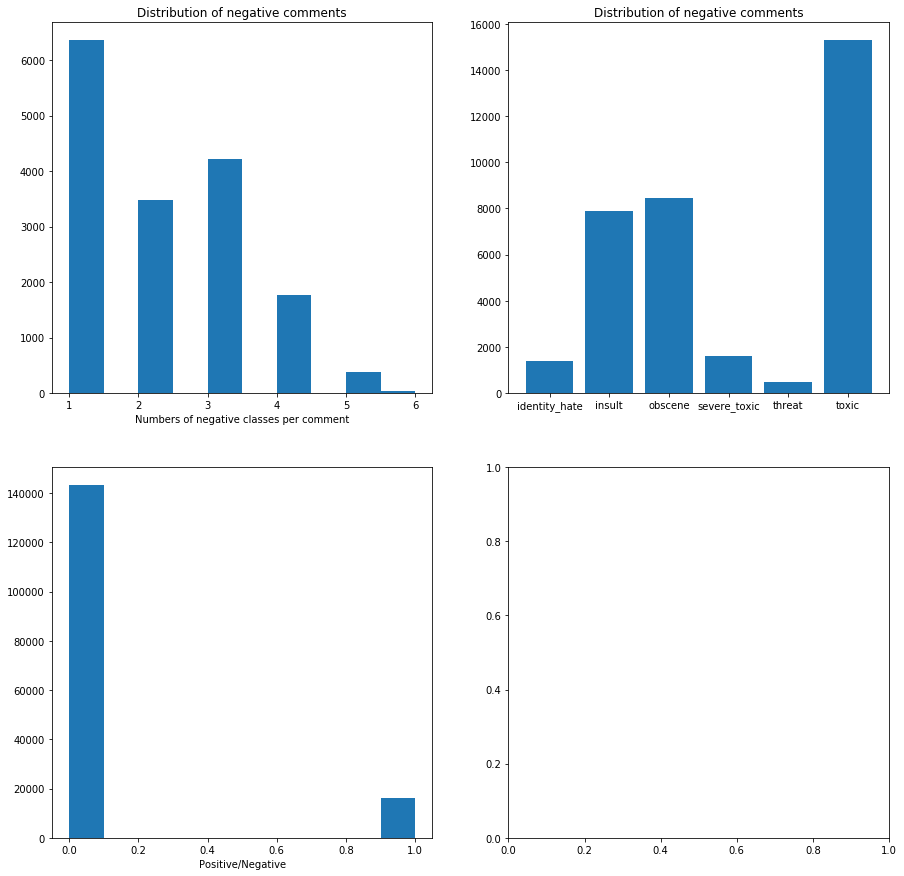

In [46]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15,15))

tot = np.array(np.sum(df.iloc[:,2:], axis = 1))
tot_bad = tot[np.where(tot != 0)]
tot_all = tot > 0

tot_tr = np.sum(df.iloc[:,2:], axis = 0)

ax[0,0].hist(tot_bad)
ax[0,0].set_title('Distribution of negative comments')
ax[0,0].set_xlabel('Numbers of negative classes per comment')
ax[0,1].bar(tot_tr.index, tot_tr)
ax[0,1].set_title('Distribution of negative comments')
ax[1,0].hist(tot_all.astype(np.int))
ax[1,0].set_xlabel('Positive/Negative')

In [ ]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000)
word_vectorizer.fit(df.iloc[:,1])

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000)
char_vectorizer.fit(df.iloc[:,1])

train_word_features = word_vectorizer.transform(X_train)
test_word_features = word_vectorizer.transform(X_test)

train_char_features = char_vectorizer.transform(X_train)
test_char_features = char_vectorizer.transform(X_test)
X_train = hstack([train_char_features, train_word_features]).tocsr()
X_test = hstack([test_char_features, test_word_features]).tocsr()

In [ ]:


opt = BayesSearchCV(
    OneVsRestClassifier(SGDClassifier(tol = 1e-10, n_jobs=-1, max_iter = 1000)),
    {   'estimator__loss': ['log', 'hinge','modified_huber', 'perceptron'],
        'estimator__penalty':['l1', 'l2', 'elasticnet'],
        'estimator__alpha': (1e-6, 1e+6, 'log-uniform')
    },
    n_iter=1
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

fitting ovr...
fitting chain 0...
fitting chain 1...
fitting chain 2...
fitting chain 3...
fitting chain 4...
fitting chain 5...
fitting chain 6...
fitting chain 7...
fitting chain 8...
fitting chain 9...
Done!


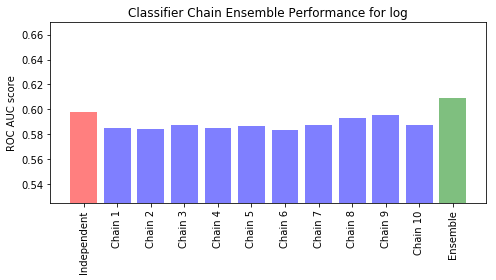

fitting ovr...
fitting chain 0...
fitting chain 1...
fitting chain 2...
fitting chain 3...
fitting chain 4...
fitting chain 5...
fitting chain 6...
fitting chain 7...
fitting chain 8...
fitting chain 9...
Done!


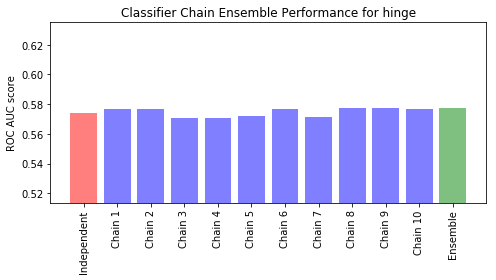

fitting ovr...
fitting chain 0...
fitting chain 1...
fitting chain 2...
fitting chain 3...
fitting chain 4...
fitting chain 5...
fitting chain 6...
fitting chain 7...
fitting chain 8...
fitting chain 9...
Done!


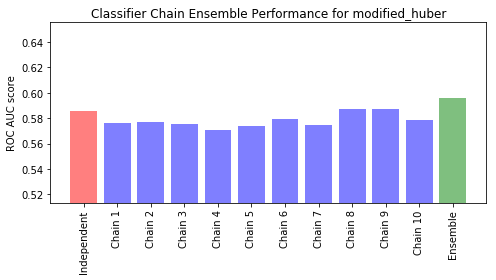

fitting ovr...
fitting chain 0...
fitting chain 1...
fitting chain 2...
fitting chain 3...
fitting chain 4...
fitting chain 5...
fitting chain 6...
fitting chain 7...
fitting chain 8...
fitting chain 9...
Done!


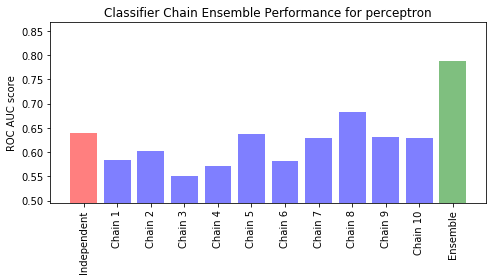

In [ ]:


num_chains = 10
ovr_score = []
chain_scores = [[] for i in range(len(loss))]
ensemble_score = []

for j, loss in enumerate(loss):
    # Independent
    clf = SGDClassifier(loss = loss, tol = 1e-10, penalty = 'l1', n_jobs=-1, max_iter=10000)
    ovr = OneVsRestClassifier(clf)
    print('fitting ovr...')
    ovr.fit(X_train, y_train)
    y_pred_ovr = ovr.predict(X_test)
    ovr_score.append(roc_auc_score(y_test, y_pred_ovr))

    # Chains
    chains = [ClassifierChain(clf, order='random', random_state=i) for i in range(num_chains)]

    for k, chain in enumerate(chains):
        print('fitting chain {}...'.format(k))
        chain.fit(X_train, y_train)
    print('Done!')
    
    y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
    chain_scores[j] = [roc_auc_score(y_test, y_pred_chain)
                         for y_pred_chain in y_pred_chains]

    y_pred_ensemble = y_pred_chains.mean(axis=0)
    ensemble_score.append(roc_auc_score(y_test,  y_pred_ensemble))

    model_scores = [ovr_score[j]] + chain_scores[j] + [ensemble_score[j]]
    

    model_names = ['Independent'] + ['Chain {}'.format(c+1) for c in range(num_chains)] + ['Ensemble']

    x_pos = np.arange(len(model_names))

# # Plot the Jaccard similarity scores for the independent model, each of the
# # chains, and the ensemble (note that the vertical axis on this plot does
# # not begin at 0).

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.set_title('Classifier Chain Ensemble Performance for {}'.format(loss))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation='vertical')
    ax.set_ylabel('ROC AUC score')
    ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
    colors = ['r'] + ['b'] * len(chain_scores[j]) + ['g']
    ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
    plt.tight_layout()
    plt.show()

In [ ]:
y_pred_chains

### NN

Generating vocabulary... Completed
Creating train dataset... Completed
Creating validation dataset... Completed


In [ ]:
class LSTMBinary(nn.Module):
    def __init__(self, 
                 vocab_size=20000, 
                 embedding_dim = 100, 
                 hidden_dim=64, 
                 batch_size=10, 
                 conv_channels=32, 
                 use_cuda=True,
                 num_of_cl_features=4):
        """
            A model from paper "A Convolutional Attention Model for Text Classification" 
            by Jiachen Du, Lin Gui, Ruifeng Xu, Yulan He 
            http://tcci.ccf.org.cn/conference/2017/papers/1057.pdf
            With modified outter layer (softmax -> sigmoid) for multilabel classification
            and added character level features
            
        """
        super(LSTMBinary, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.conv_channels = conv_channels
        self.use_cuda = use_cuda
        self.num_of_cl_features = num_of_cl_features
        
        if(self.use_cuda):
            self.embeddings = nn.Embedding(vocab_size, embedding_dim=embedding_dim).cuda()
            self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim // 2, 
                            num_layers=1, bidirectional=True, batch_first=True).cuda()
                 # // 2 is because we would like to concat hidden states, 
                # calculated from both sides of LSTM and aquire exactly hidden_dim
            
            self.conv = nn.Conv1d(in_channels=embedding_dim, 
                                  out_channels=conv_channels, 
                                  kernel_size=5, 
                                  padding=2).cuda()
    
            self.linear = nn.Linear(conv_channels, 1).cuda()
            self.linear_final = nn.Linear(hidden_dim + num_of_cl_features, 2).cuda() 
            # we have 6 classes to predict
        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim=embedding_dim)
            self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim // 2, 
                            num_layers=1, bidirectional=True, batch_first=True)
            
            self.conv = nn.Conv1d(in_channels=embedding_dim, 
                                  out_channels=conv_channels, 
                                  kernel_size=5, 
                                  padding=2)
    
            self.linear = nn.Linear(conv_channels, 1)
            self.linear_final = nn.Linear(hidden_dim + num_of_cl_features, 2) 
            
        self.init_hidden()
        
        
    def init_hidden(self):
        if(self.use_cuda):
            self.hidden = (Variable(torch.zeros(2, 
                                                self.batch_size, 
                                                self.hidden_dim // 2)).cuda(), 
                           Variable(torch.zeros(2, 
                                                self.batch_size, 
                                                self.hidden_dim // 2)).cuda())
        else:
            self.hidden = (Variable(torch.zeros(2, 
                                                self.batch_size, 
                                                self.hidden_dim // 2)), 
                           Variable(torch.zeros(2, 
                                                self.batch_size, 
                                                self.hidden_dim // 2)))
    
    def forward(self, input_seq, cl_features=None):
        embed = self.embeddings(input_seq)
        output, _ = self.lstm(embed, self.hidden)
        
        conv_out = self.conv(embed.permute(0, 2, 1))
        
        attention_tensor = torch.mean(conv_out, dim=1)
        
        features = torch.sum(output * attention_tensor.resize(attention_tensor.data.shape[0], attention_tensor.data.shape[1], 1), dim=1)
        
        if(cl_features is not None and self.num_of_cl_features == cl_features.data.shape[1]):
            features = torch.cat((features, cl_features), dim=1)
        elif(cl_features is not None and self.num_of_cl_features != cl_features.data.shape[1]):
            print("""Recieved unexpected number of character level features. 
                     Model expected to recieve {} features, but received {}. 
                     Check model constructor or sample passed in forward""".format(self.num_of_cl_features, cl_features.data.shape[1]))
            raise ValueError()
        elif(cl_features is None and self.num_of_cl_features > 0):
            print("""Model expected to recieve {} features, but received None. 
                     Check model constructor or sample passed in forward""".format(self.num_of_cl_features))
            raise ValueError()
            
        predictions = nn.functional.softmax(self.linear_final(features), dim = 1)
        
        return predictions
    
#     def fit(self, lr, weight_decay, epochs):
#         optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

#         if(use_cuda): loss_function = nn.MultiLabelSoftMarginLoss().cuda()
#         else: loss_function = nn.MultiLabelSoftMarginLoss()

#         start = time.time()
#         for i in range(epochs):
#             train_stats['train_loss'].append(0)
#             train_stats['valid_loss'].append(0)
#             all_predictions = Variable(torch.zeros(1))
#             all_true_labels = Variable(torch.zeros(1))

#             for mode in ['train', 'valid']:
#                 dataset.mode = mode
#                 dataset.shuffle()
#                 for sample in dataset:
#                     if(mode == 'train'):
#                         optimizer.zero_grad()
#                         model.init_hidden()

#                         pred = model.forward(sample['input'], sample['cl_features'])[:,0]
#                         loss = loss_function(pred, sample['labels'][:,target])
#                         loss.backward()
#                         optimizer.step()
#                         train_stats['train_loss'][-1] += loss.data[0]
        

In [ ]:
batch_size = 6
use_cuda = True
validation_size = 0.15
vocab_size = 3000
n_train_batches = 1000
n_valid_batches = 500
label_index = 0

dataset = ToxicTextsDataset(label_index = 0,n_test_batches=1, 
                            n_train_batches=n_train_batches, 
                            n_valid_batches=n_valid_batches,
                            valid_size=validation_size,
                            test_size=0.,
                            batch_size=batch_size, 
                            vocab_size=vocab_size, 
                            verbose=1,
                            use_cuda = use_cuda)

NameError: name 'ToxicTextsDatasetBinary' is not defined

In [ ]:
lr = 1e-3
weight_decay = 1e-5
embedding_dim = 20
hidden_dim = 10
conv_channels = 32
target = 0


epochs = 15

train_stats = {'train_loss':[0], 'valid_loss':[0], 'roc_auc_score':[]}

model = LSTMBinary(vocab_size=vocab_size, 
                   embedding_dim = embedding_dim, 
                   hidden_dim=hidden_dim, 
                   conv_channels=conv_channels,
                               batch_size=batch_size, 
                               use_cuda=use_cuda)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

if(use_cuda): loss_function = nn.MultiLabelSoftMarginLoss().cuda()
else: loss_function = nn.Ent()


start = time.time()
for i in range(epochs):
    train_stats['train_loss'].append(0)
    train_stats['valid_loss'].append(0)
    all_predictions = Variable(torch.zeros(1))
    all_true_labels = Variable(torch.zeros(1))

    for mode in ['train', 'valid']:
        dataset.mode = mode
        dataset.shuffle()
        for sample in dataset:
            if(mode == 'train'):
                optimizer.zero_grad()
                model.init_hidden()

                pred = model.forward(sample['input'], sample['cl_features'])[:,0]
                loss = loss_function(pred, sample['labels'][:,target])
                loss.backward()
                optimizer.step()
                train_stats['train_loss'][-1] += loss.data[0]
            else:
                model.init_hidden()
                pred = model.forward(sample['input'], sample['cl_features'])[:,0]
                train_stats['valid_loss'][-1] += loss_function(pred, sample['labels'][:,target]).data[0]
                all_predictions = torch.cat((all_predictions, pred.cpu()))
                all_true_labels = torch.cat((all_true_labels, sample['labels'][:,target].cpu()))

            
    all_predictions = all_predictions.data.numpy()
    all_true_labels = all_true_labels.data.numpy()       
    train_stats['roc_auc_score'].append(roc_auc_score(all_true_labels, all_predictions))
            
            
    print('Epoch {:03d}; train loss = {:4.2f}; validation loss = {:2.2f}; validation roc auc score= {:0.2f}; ETA = {:3.0f} s\n'.format(i+1, 
                                                                              train_stats['train_loss'][-1], 
                                                                              train_stats['valid_loss'][-1], 
                                                                              train_stats['roc_auc_score'][-1],
                                                                             (epochs - i)*(time.time() - start)/(i+1)))

Epoch 000; train loss = 662.05; validation loss = 315.00; validation roc auc score= 0.69; ETA = 616 s

Epoch 001; train loss = 599.59; validation loss = 317.02; validation roc auc score= 0.77; ETA = 568 s

Epoch 002; train loss = 570.16; validation loss = 291.97; validation roc auc score= 0.80; ETA = 534 s

Epoch 003; train loss = 561.76; validation loss = 306.40; validation roc auc score= 0.81; ETA = 490 s

Epoch 004; train loss = 548.27; validation loss = 289.19; validation roc auc score= 0.83; ETA = 450 s

Epoch 005; train loss = 539.79; validation loss = 290.09; validation roc auc score= 0.82; ETA = 409 s

Epoch 006; train loss = 538.46; validation loss = 294.73; validation roc auc score= 0.82; ETA = 369 s

Epoch 007; train loss = 527.82; validation loss = 292.38; validation roc auc score= 0.81; ETA = 329 s

Epoch 008; train loss = 526.35; validation loss = 303.93; validation roc auc score= 0.81; ETA = 289 s

Epoch 009; train loss = 535.54; validation loss = 291.35; validation roc 

* Нейронка для бинарной классификации
* Надо добавить фичу (результат предыдущих классификаторов)

In [ ]:
def ChainingClassifier(target, target_num):
    # получаем новые фичи
    for i in range(target_num):
        